In [1]:
#실전 ! 케라스 API를 이용해 합성곱 신경망 모델을 만들어보자

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

1. 완전 연결 신경망과의 차이점 : 완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야 했다. 그러나 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 일렬로 펼치지 않아도 된다.
2. 입력 이미지는 항상 깊이(채널) 차원이 있어야 한다. 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만, Conv2D층을 사용하기 위해 마지막에 이 채널 차원을 추가해야 한다.

In [6]:
#데이터 준비 후 본격적으로 합성곱 신경망 만들기

model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1))) 
#합성곱 층인 Conv2D 추가, 32개의 필터 사용, 커널의 크기, 렐루 활성화 함수 사용, 세임 패딩 사용, 깊이가 있도록 (28,28)에서 (28,28,1)로 ..

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
#풀링층 추가
model.add(keras.layers.MaxPooling2D(2))

In [10]:
#첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층 추가
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')) #필터의 개수 64개로 증가
model.add(keras.layers.MaxPooling2D(2))

In [12]:
#3차원 특성 맵을 일렬로 펼칠 차례이다. 마지막에 10개의 뉴런을 가진 출력층에서 확률을 계산하기 때문이다.
#특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 둘 것이다. (Flatten - Dense 은닉 - Dense 출력)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu')) #100개의 뉴런 사용
model.add(keras.layers.Dropout(0.4)) #과대적합을 막기 위함
model.add(keras.layers.Dense(10, activation='softmax'))

In [14]:
#모델 구조 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
!pip install pydot
!pip install graphviz

In [30]:
#층의 구성을 그림으로 표현
from keras.utils import plot_model

keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


콜론 왼쪽에는 층의 이름이 쓰여 있고 오른쪽에는 클래스가 나타난다.

In [33]:
keras.utils.plot_model(model, show_shapes=True) #show_shapes=True -> 그림에 입력과 출력의 크기를 표시해준다.

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [35]:
#합성곱 신경망 모델 컴파일 및 훈련
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras',\
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history=model.fit(train_scaled, train_target, epochs=20,
                  validation_data=(val_scaled, val_target),
                  callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7362 - loss: 0.7278 - val_accuracy: 0.8792 - val_loss: 0.3313
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.8692 - loss: 0.3659 - val_accuracy: 0.8929 - val_loss: 0.2870
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.8874 - loss: 0.3137 - val_accuracy: 0.9064 - val_loss: 0.2551
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.8978 - loss: 0.2767 - val_accuracy: 0.9086 - val_loss: 0.2455
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9105 - loss: 0.2426 - val_accuracy: 0.9096 - val_loss: 0.2429
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9186 - loss: 0.2258 - val_accuracy: 0.9147 - val_loss: 0.2299
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.9246 - loss: 0.2050 - val_accuracy: 0.9190 - val_loss: 0.2283
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9288 -

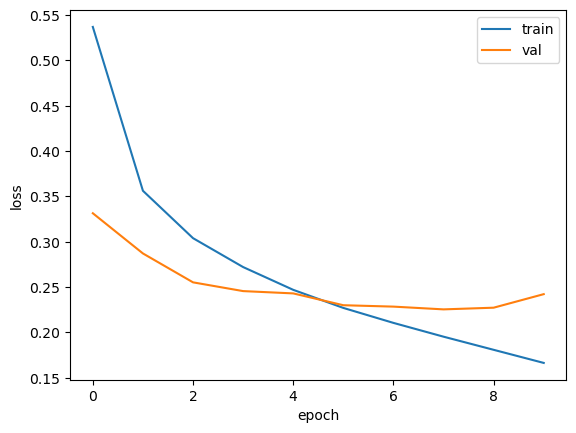

In [37]:
#손실 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 세트에 대한 손실은 점차 감소하다가 정체되기 시작하고
훈련 세트에 대한 손실은 점점 더 낮아지고 있다.



이 그래프를 기반으로 9번째 에포크를 최적으로 생각할 수 있다.

In [40]:
#EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체가 최적의 모델 파라미터로 복원되어 있다.
#즉 ModelCheckpoint 콜백이 저장한 best-cnn-model.keras 파일을 다시 읽을 필요가 없다.

#세트에 대한 성능 평가
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9209 - loss: 0.2158


[0.22529096901416779, 0.9182500243186951]

책에서는 위 결과가 fit() 메서드의 출력 중 아홉 번째 에포크의 출력과 동일하다.


EarlyStopping 콜백이 model 객체를 최상의 모델 파라미터로 잘 복원한 것 같다.

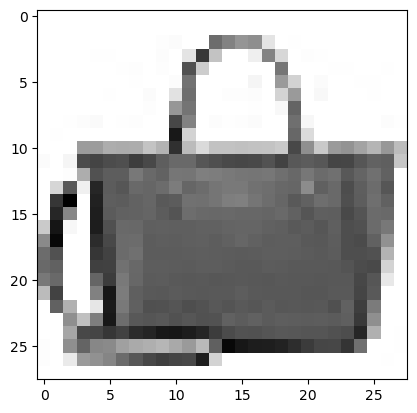

In [43]:
#predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측 만들기

plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r') #맷플롯립에서 흑백 이미지에 깊이 차원은 없기 때문에 (28,28,1) 크기를 (28,28)로 바꾸어 출력
plt.show()

In [45]:
#predict() 메서드는 10개의 클래스에 대한 각각의 예측 확률 출력
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[3.6944940e-21 3.4543067e-27 4.0915697e-21 3.3339796e-22 2.3261153e-16
  6.2252177e-17 2.6613527e-18 4.1881734e-18 1.0000000e+00 8.4914427e-19]]


아홉 번째 값이 1인 것을 보아 아홉 번째 클래스라고 강하게 주장하는 것이다.

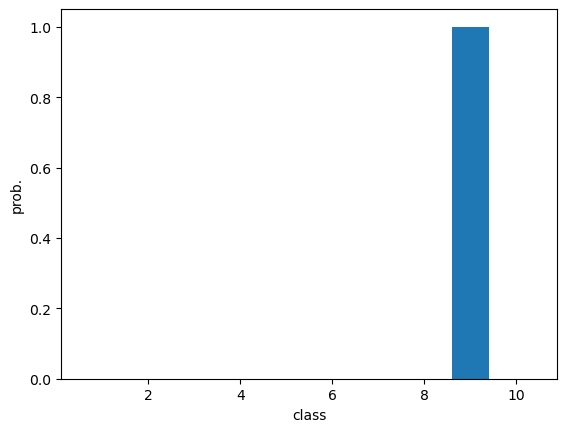

In [48]:
#이를 막대그래프로 그려보자

plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [50]:
#아홉 번째 클래스가 실제로 무엇인지 알기 쉽기 위해 파이썬에서 리스트로 저장
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [52]:
#클래스 리스트가 있으면 레이블을 출력하기 쉽다.
import numpy as np
print(classes[np.argmax(preds)])

가방


In [54]:
#테스트 세트로 합성곱 신경망의 일반화 성능 가늠
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0 #이미지 크기 및 픽셀값의 범위 바꾸기
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9181 - loss: 0.2472


[0.24171267449855804, 0.9179999828338623]

In [56]:
#예상대로 테스트 세트에서의 점수는 검증 세트보다 조금 더 작다 ! 
#이 모델을 실전에 투입하여 패션 아이템을 분류한다면 약 91%의 성능 기대 !